# Create multi-label chips for multi-output regression sampled from the whole GB

Create chips and store proportions of signature types within as an input of multi-output regression problem

In [1]:
import geopandas
import tobler
import pyogrio
import pygeos
import numpy
import pandas
import dask_geopandas
import rasterio
from scipy.sparse import coo_matrix

import dask
import dask.bag
from dask.distributed import Client, LocalCluster

In [2]:
%%time
df = geopandas.read_parquet("/home/jovyan/work/chips_gb/chip_bounds_32/").reset_index(drop=True)

CPU times: user 1.76 s, sys: 710 ms, total: 2.47 s
Wall time: 1.93 s


In [3]:
df

,geometry
0,"POLYGON ((82941.267 7070.753, 82941.267 6750.7..."
1,"POLYGON ((83261.267 7070.753, 83261.267 6750.7..."
2,"POLYGON ((86141.267 8990.753, 86141.267 8670.7..."
3,"POLYGON ((86461.267 8670.753, 86461.267 8350.7..."
4,"POLYGON ((87741.267 8030.753, 87741.267 7710.7..."
...,...
1714349,"POLYGON ((353981.267 103710.753, 353981.267 10..."
1714350,"POLYGON ((359741.267 104030.753, 359741.267 10..."
1714351,"POLYGON ((360061.267 103070.753, 360061.267 10..."
1714352,"POLYGON ((360061.267 103390.753, 360061.267 10..."


In [4]:
signatures = pyogrio.read_dataframe(        
        '/home/jovyan/work/urbangrammar_samba/spatial_signatures/'
        'signatures/'
        'signatures_combined_levels_simplified.gpkg'
)

In [5]:
bds = df.total_bounds
signatures = signatures.cx[bds[0]:bds[2], bds[1]:bds[3]]

In [6]:
%%time

ids_src, ids_tgt = df.sindex.query_bulk(signatures.geometry, predicate="intersects")

CPU times: user 45.2 s, sys: 101 ms, total: 45.3 s
Wall time: 45.3 s


In [7]:
od_matrix = pandas.DataFrame(dict(ids_src=ids_src, ids_tgt=ids_tgt))

In [8]:
%%time 
sjoined = df.set_geometry(df.centroid).sjoin(signatures[["signature_type", "geometry"]], how="left", predicate="within")

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1938: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:27700

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


CPU times: user 6.79 s, sys: 332 ms, total: 7.12 s
Wall time: 7.11 s


In [9]:
od_matrix["signature_type"] = sjoined.signature_type.iloc[ids_tgt].values

<AxesSubplot:>

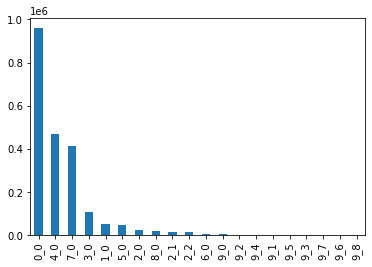

In [10]:
od_matrix.signature_type.value_counts().plot.bar()

In [11]:
od_matrix.signature_type.value_counts()

0_0    960161
4_0    466684
7_0    413131
3_0    105205
1_0     49072
5_0     46155
2_0     23743
8_0     17398
2_1     14081
2_2     12232
6_0      5687
9_0      4454
9_2      1532
9_4       314
9_1       146
9_5        61
9_3         5
9_7         4
9_6         2
9_8         1
Name: signature_type, dtype: int64

In [12]:
cap = 20000
keep = []
counts = {k:0 for k in od_matrix.signature_type.unique()}
for i, t in od_matrix.signature_type.sample(len(od_matrix)).iteritems():
    counts[t] += 1
    if counts[t] < cap:
        keep.append(i)

In [13]:
limited = od_matrix.iloc[keep]

<AxesSubplot:>

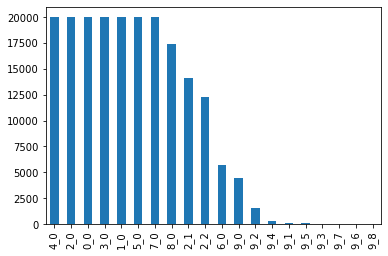

In [14]:
limited.signature_type.value_counts().plot.bar()

In [49]:
limited.shape

(195910, 3)

In [29]:
%%time
chips = df.geometry.values[limited.ids_tgt.values].data
sig = signatures.geometry.values[limited.ids_src.values].data

# this could be parallelised
r = [
    pygeos.clip_by_rect(
        g, *chip
    ) for g, chip in zip(sig, pygeos.bounds(chips))
]

areas = pygeos.area(r)

table = coo_matrix(
    (
        areas,
        (limited.ids_src.values, limited.ids_tgt.values),
    ),
    shape=(signatures.shape[0], df.shape[0]),
    dtype=numpy.float32,
)

table = table.tocsr()

CPU times: user 1min 45s, sys: 15.6 ms, total: 1min 45s
Wall time: 1min 45s


In [18]:
%%time
signatures["signature_type"] = pandas.Categorical(signatures["signature_type"])

CPU times: user 13.5 ms, sys: 3.91 ms, total: 17.4 ms
Wall time: 15.1 ms


In [36]:
%%time
categorical = {}
for value in unique:
    mask = signatures["signature_type"] == value
    categorical[value] = numpy.asarray(
        table[mask].sum(axis=0)
    )[0]
    print(value)

0_0
1_0
3_0
4_0
5_0
6_0
7_0
8_0
2_0
2_1
2_2
9_0
9_1
9_2
9_3
9_4
9_5
9_6
9_7
9_8
CPU times: user 94.8 ms, sys: 1e+03 ns, total: 94.8 ms
Wall time: 90.9 ms


In [38]:
%%time
categorical = pandas.DataFrame(categorical)

CPU times: user 14.1 ms, sys: 16 ms, total: 30.1 ms
Wall time: 28.1 ms


In [39]:
%time areas = df.area.values
%time categorical = categorical.div(areas, axis="rows")

CPU times: user 82.8 ms, sys: 13 µs, total: 82.8 ms
Wall time: 80.2 ms
CPU times: user 47.4 ms, sys: 28 ms, total: 75.4 ms
Wall time: 74.9 ms


In [47]:
(categorical.sum(axis=1) == 0).sum()

/tmp/ipykernel_10598/4274778219.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  (categorical.sum(axis=1) == 0).sum()


1579640

In [45]:
geom = df[df.geometry.name].reset_index(drop=True)
ests = geopandas.GeoDataFrame(categorical, geometry=geom, crs=signatures.crs)

In [50]:
limited

,ids_src,ids_tgt,signature_type
1190660,37738,1386891,4_0
8904,195,81173,0_0
692446,339,1541762,0_0
1354489,37957,463057,4_0
430094,339,284707,0_0
...,...,...,...
2072606,79139,973418,6_0
2089379,83646,591044,8_0
2063114,76927,425012,8_0
2118769,91222,703237,2_2


In [51]:
ests = ests.iloc[limited.ids_tgt.values]

<AxesSubplot:>

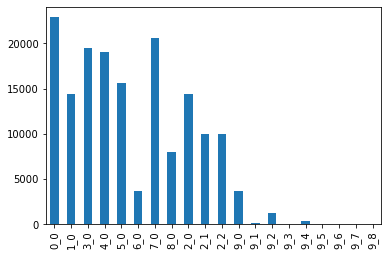

In [53]:
ests.drop(columns="geometry").sum().plot.bar()

In [56]:
ests.to_parquet("/home/jovyan/work/chips_gb/chip_proportions_32.pq")

/tmp/ipykernel_10598/3186613818.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  ests.to_parquet("/home/jovyan/work/chips_gb/chip_proportions_32.pq")


<AxesSubplot:>

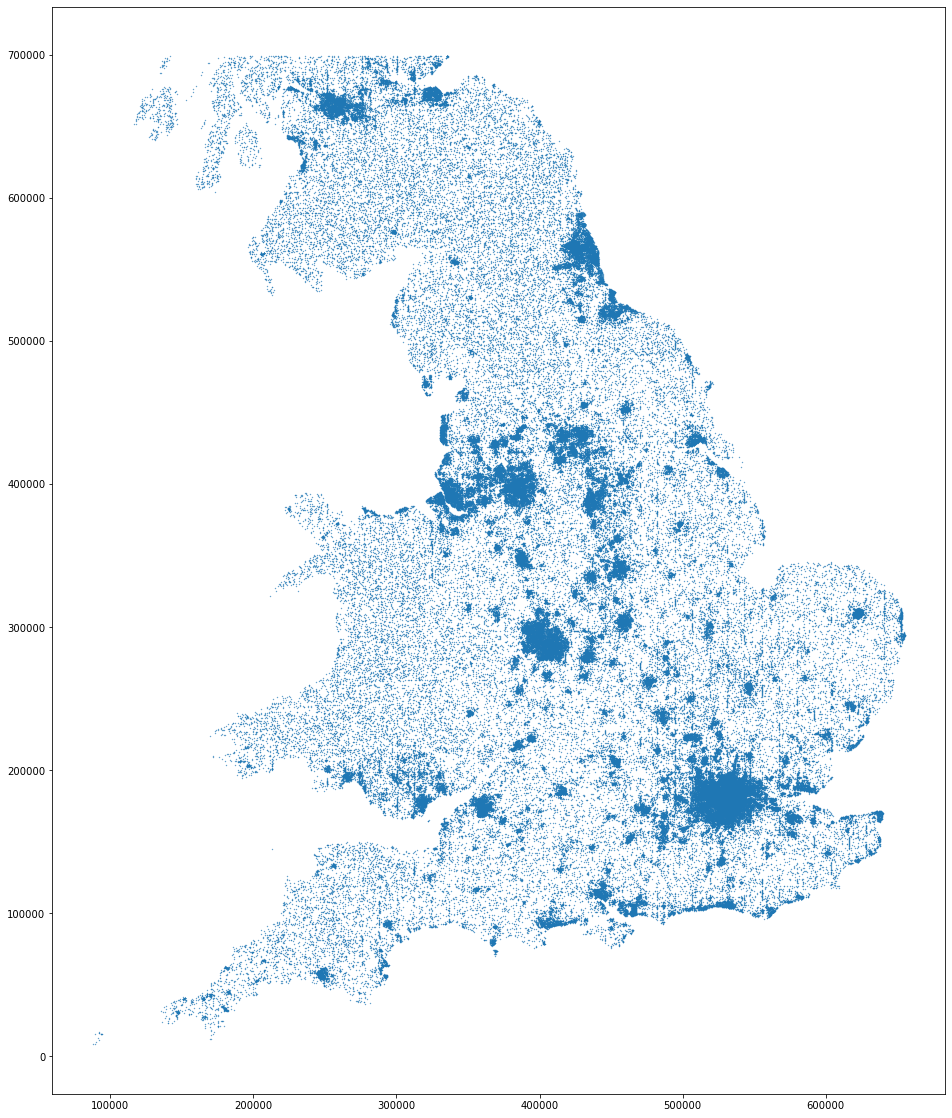

In [58]:
ests.centroid.plot(figsize=(20, 20), markersize=.1)

Create chips

In [2]:
specs = {
    'chip_size': 32,
    'bands': [1, 2, 3], #RGB
    'mosaic_p': (
        '/home/jovyan/work/urbangrammar_samba/'
        'ghs_composite_s2/GHS-composite-S2.vrt'
    ),
}

In [3]:
bounds = geopandas.read_parquet("/home/jovyan/work/chips_gb/chip_proportions_32.pq")

In [4]:
centroid = bounds.centroid
bounds['X'] = centroid.x.astype(int)
bounds['Y'] = centroid.y.astype(int)

In [5]:
client = Client(
    LocalCluster(n_workers=16, threads_per_worker=1)
)
client

distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/work/signature_ai/create_chips/dask-worker-space/worker-74m5r0sy', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 125.54 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35883,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 125.54 GiB
Comm: tcp://127.0.0.1:41387,Total threads: 1
Dashboard: http://127.0.0.1:43521/status,Memory: 7.85 GiB
Nanny: tcp://127.0.0.1:35195,


In [6]:
import numpy as np

def bag_of_chips(chip_bbs, specs, npartitions):
    '''
    Load imagery for `chip_bbs` using a Dask bag
    ...
    
    Arguments
    ---------
    chip_bbs : GeoDataFrame
               Geo-table with bounding boxes of the chips to load
    specs : dict
            Metadata dict, including, at least:
            - `bands`: band index of each band of interest
            - `chip_size`: size of each chip size expressed in pixels
            - `mosaic_p`: path to the mosaic/file of imagery
    npartitions : int
                  No. of partitions to split `chip_bbs` before sending to
                  Dask for distributed computation
    Returns
    -------
    chips : ndarray
            Numpy tensor of (N, chip_size, chip_size, n_bands) dimension 
            with imagery data   
    '''
    # Split chip_bbs
    thr = np.linspace(0, chip_bbs.shape[0], npartitions+1, dtype=int)
    chunks = [
        (chip_bbs.iloc[thr[i]:thr[i+1], :], specs) for i in range(len(thr)-1)
    ]
    # Set up the bag
    bag = dask.bag.from_sequence(
        chunks, npartitions=npartitions
    ).map(chip_loader)
    # Compute
    chips = np.concatenate(bag.compute())
    return chips


def chip_loader(pars):
    '''
    Load imagery for `chip_bbs`
    ...
    
    Arguments (wrapped in `pars`)
    -----------------------------
    chip_bbs : GeoDataFrame
               Geo-table with bounding boxes of the chips to load
    specs : dict
            Metadata dict, including, at least:
            - `bands`: band index of each band of interest
            - `chip_size`: size of each chip size expressed in pixels
            - `mosaic_p`: path to the mosaic/file of imagery
    Returns
    -------
    chips : ndarray
            Numpy tensor of (N, chip_size, chip_size, n_bands) dimension 
            with imagery data
    '''
    chip_bbs, specs = pars
    b = len(specs['bands'])
    s = specs['chip_size']
    chips = np.zeros((chip_bbs.shape[0], b, s, s))
    with rasterio.open(specs['mosaic_p']) as src:
        for i, tup in enumerate(chip_bbs.itertuples()):
            img, transform = rasterio.mask.mask(
                src, [tup.geometry], crop=True, all_touched=True
            )
            img = img[:b, :s, :s]
            for ban, (l_min, l_max) in enumerate([(350, 1600), (500, 1600), (600, 1800)]):
                img[ban][img[ban] > l_max] = l_max
                img[ban][img[ban] < l_min] = l_min
                a_std = (img[ban] - l_min) / (l_max - l_min)
                img[ban] = a_std * 255
            chips[i, :, :, :] = img
    chips = np.moveaxis(chips, 1, -1)
    return chips.astype(rasterio.uint8)

In [7]:
chips = bag_of_chips(bounds, specs, 16)

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 5.51 GiB -- Worker memory limit: 7.85 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 5.53 GiB -- Worker memory limit: 7.85 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 5.54 GiB -- Worker memory limit: 7.85 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

In [8]:
numpy.save('../../chips_gb/multilabel_chip_32.npy', chips)

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.37 GiB -- Worker memory limit: 7.85 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 5.57 GiB -- Worker memory limit: 7.85 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.28 GiB -- Worker memory limit: 7.85 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 